# Practice stuff
This is taken from NLTK chapter 7, with slight modifications :) Note that this overlaps quite a bit with the next lab on information extraction - so it pays off to read through this chapter and experiment a bit!

In [1]:
import nltk

In [2]:
# define a helper function for a given chunker, that tokenizes -> pos tags
def parse_sent(parser, sent):
    return parser.parse(nltk.pos_tag(nltk.word_tokenize(sent)))

In [3]:
sentence = "the little bear saw the fine fat trout in the brook"

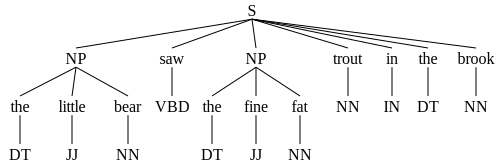

In [4]:
grammar = r"""
NP: {<DT><JJ><NN>} # DT (optional adjective) followed by NN
"""
cp = nltk.RegexpParser(grammar)
parse_sent(cp, sentence)

This isn't quite right. "The fine fat" is now a NP, not "the fine fat trout".. We must allow multiple nouns for NPs (add a +)!

Also, let's incorporate optional adjectives, such that "the brook" becomes a NP (? after the definition)

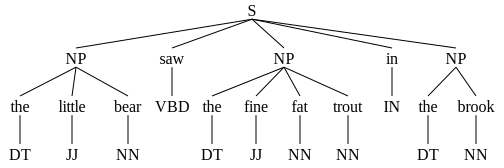

In [5]:
grammar = r"""
NP: {<DT><JJ>?<NN>+} # DT (optional adjective) followed by NN
"""
cp = nltk.RegexpParser(grammar)
parse_sent(cp, sentence)

Fixed! Now we need to support VPs as we saw in the lecture. VP = V NP or PP

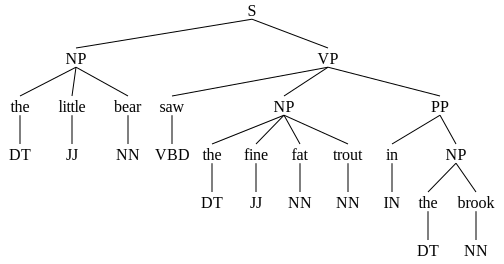

In [6]:
grammar = r"""
NP: {<DT><JJ>?<NN.*>+} # DT (optional adjective) followed by NN
PP: {<IN><NP>}         # prepositions followed by NP
VP: {<VB.*><NP|PP>+}   # match one or more of NP or PP
"""
cp = nltk.RegexpParser(grammar)
parse_sent(cp, sentence)

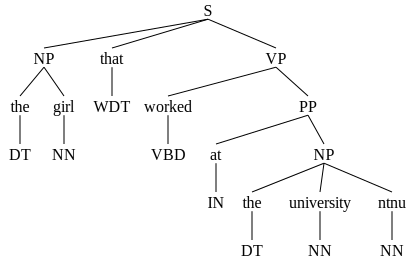

In [7]:
sentence = "the girl that worked at the university ntnu"
parse_sent(cp, sentence)

## Explore subtrees!
Use the brown corpus, iterate a few sentences and parse them with the grammar:

any verb &rarr; TO &rarr; any verb

In [8]:
cp = nltk.RegexpParser('chonker: {<V.*> <TO> <V.*>}')
brown = nltk.corpus.brown
for sent in brown.tagged_sents()[:200]:  # <-- limit to avoid print spam
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'chonker':
            print(" ".join([w for w, POS in subtree.leaves()]))

combined to achieve
continue to place
serve to protect
wanted to wait
allowed to place
expected to become
expected to approve
expected to make
intends to make
seek to set
like to see
designed to provide
get to hear
expects to tell
expected to give
prefer to pay
required to obtain
permitted to teach
designed to reduce


## Reverse the operation with Chinks!

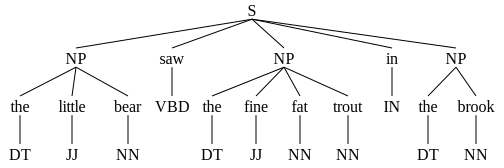

In [9]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<V.*|IN>+{      # Chink sequences of V and IN
  """
cp = nltk.RegexpParser(grammar)
sentence = "the little bear saw the fine fat trout in the brook"
parse_sent(cp, sentence)

Observe how the `DT JJ JJ NN` sequence is now a NN because of the VBD|IN chink!

We also chunked "the brook" correctly. Amazing!

# Evaluation with predfined chunked sentences
Using annotated data sets, you can create your own chunker and evaluate it on true sentences :)

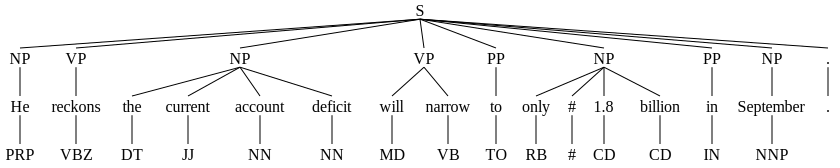

In [10]:
wsj = nltk.corpus.conll2000
wsj.chunked_sents("train.txt")[10]

## specify chunk types
only chunks on NPs. Note how the VP above is now not chunked.

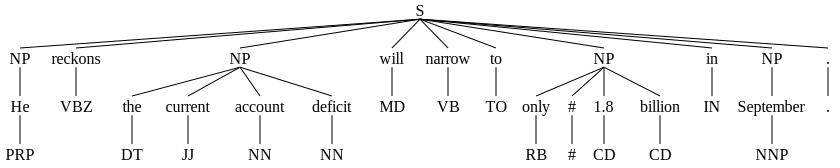

In [11]:
wsj.chunked_sents("train.txt", chunk_types=["NP"])[10]

In [12]:
cp = nltk.RegexpParser("")  # empty regex parser
train_sents = wsj.chunked_sents('train.txt', chunk_types=['NP'])
test_sents = wsj.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


In [13]:
grammar = r"NP: {<[CDJNP].*>+}"  # populate some rules
cp = nltk.RegexpParser(grammar)
print(cp.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


## Improve with a custom chunker!
use the training corpus to find the chunk tag (I, O, or B) that is most likely for each part-of-speech tag. In other words, we can build a chunker using a unigram tagger. But rather than trying to determine the correct part-of-speech tag for each word, we are trying to determine the correct chunk tag, given each word's part-of-speech tag.

In [14]:
class NgramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents, tagger=nltk.UnigramTagger):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = tagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [15]:
ngram_chunker = NgramChunker(
    train_sents,
    tagger=nltk.BigramTagger
    # can be unigram, trigram, or whatever you implemented in earlier labs
)

In [16]:
print(ngram_chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


## Recursion

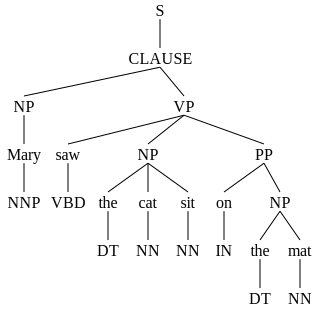

In [17]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
txt = "Mary saw the cat sit on the mat"
parse_sent(cp, txt)

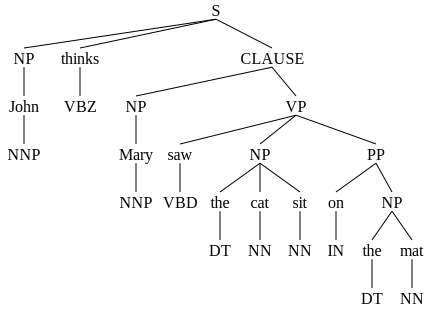

In [18]:
txt = "John thinks Mary saw the cat sit on the mat"
parse_sent(cp, txt)

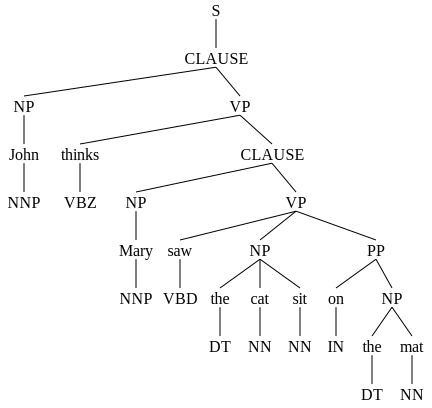

In [19]:
cp = nltk.RegexpParser(grammar, loop=2)
parse_sent(cp, txt)

# tree traversal
a generic traverse algo

In [20]:
def traverse(t):
    try:
        t.label()
    except AttributeError:
        print(t, end=" ")
    else:
        # Now we know that t.node is defined
        print('(', t.label(), end=" ")
        for child in t:
            traverse(child)
        print(')', end=" ")

In [21]:
tree = parse_sent(cp, txt)
traverse(tree)

( S ( CLAUSE ( NP ('John', 'NNP') ) ( VP ('thinks', 'VBZ') ( CLAUSE ( NP ('Mary', 'NNP') ) ( VP ('saw', 'VBD') ( NP ('the', 'DT') ('cat', 'NN') ('sit', 'NN') ) ( PP ('on', 'IN') ( NP ('the', 'DT') ('mat', 'NN') ) ) ) ) ) ) ) 

# named entity recognition!

In [22]:
sent = nltk.corpus.treebank.tagged_sents()[1]
print(" ".join([w for w, pos in sent]))

Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .


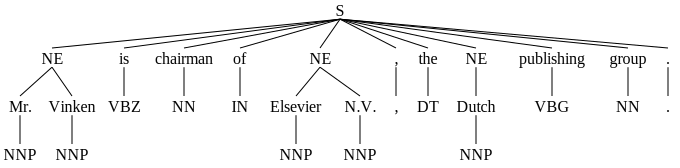

In [23]:
nltk.ne_chunk(sent, binary=True)

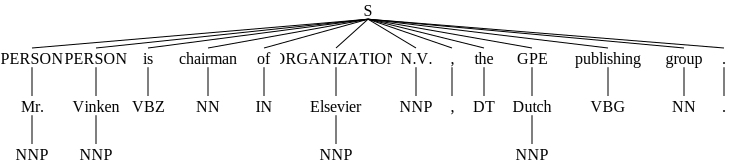

In [24]:
nltk.ne_chunk(sent)  # note how this separates singular entities

In [25]:
import re
pattern = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc, corpus='ieer', pattern=pattern):
        print(nltk.sem.rtuple(rel))

[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


In [26]:
from nltk.corpus import conll2002
vnv = """
(
is/V|    # 3rd sing present and
was/V|   # past forms of the verb zijn ('be')
werd/V|  # and also present
wordt/V  # past of worden ('become)
)
.*       # followed by anything
van/Prep # followed by van ('of')
"""
VAN = re.compile(vnv, re.VERBOSE)
for doc in conll2002.chunked_sents('ned.train'):
    for rel in nltk.sem.extract_rels('PER', 'ORG', doc,
                                     corpus='conll2002', pattern=VAN):
        print(nltk.sem.clause(rel, relsym="VAN"))
        print(nltk.rtuple(rel, lcon=True, rcon=True))

VAN("cornet_d'elzius", 'buitenlandse_handel')
...'')[PER: "Cornet/V d'Elzius/N"] 'is/V op/Prep dit/Pron ogenblik/N kabinetsadviseur/N van/Prep staatssecretaris/N voor/Prep' [ORG: 'Buitenlandse/N Handel/N'](''...
VAN('johan_rottiers', 'kardinaal_van_roey_instituut')
...'')[PER: 'Johan/N Rottiers/N'] 'is/V informaticacoördinator/N van/Prep het/Art' [ORG: 'Kardinaal/N Van/N Roey/N Instituut/N']('in/Prep'...
VAN('annie_lennox', 'eurythmics')
...'Door/Prep rugproblemen/N van/Prep zangeres/N')[PER: 'Annie/N Lennox/N'] 'wordt/V het/Art concert/N van/Prep' [ORG: 'Eurythmics/N']('vandaag/Adv in/Prep'...


# Making use of treebanks

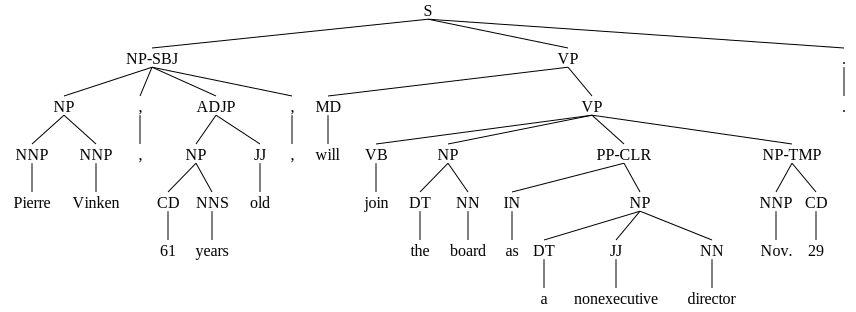

In [27]:
from nltk.corpus import treebank
t = treebank.parsed_sents('wsj_0001.mrg')[0]
t

Create a production rule of the form VP &rarr; S

In [28]:
def vp_s(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'VP') and ('S' in child_nodes)

def np_pp(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'NP') and ('PP' in child_nodes)

In [29]:
sents = treebank.parsed_sents()[:10]  # sample from first 10

def np_pp(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'NP') and ('PP' in child_nodes)
for tree in sents:
    for subtree in tree.subtrees(vp_s):
        print(subtree)


(VP
  (VBN named)
  (S
    (NP-SBJ (-NONE- *-1))
    (NP-PRD
      (NP (DT a) (JJ nonexecutive) (NN director))
      (PP
        (IN of)
        (NP (DT this) (JJ British) (JJ industrial) (NN conglomerate))))))
(VP
  (VBD said)
  (, ,)
  (`` ``)
  (S
    (NP-SBJ (DT This))
    (VP (VBZ is) (NP-PRD (DT an) (JJ old) (NN story)))))


In [30]:
for tree in sents:
    for subtree in tree.subtrees(np_pp):
        print(subtree)

(NP
  (NP (JJ former) (NN chairman))
  (PP
    (IN of)
    (NP (NNP Consolidated) (NNP Gold) (NNP Fields) (NNP PLC))))
(NP (NP (DT A) (NN form)) (PP (IN of) (NP (NN asbestos))))
(NP
  (NP (DT a) (JJ high) (NN percentage))
  (PP (IN of) (NP (NN cancer) (NNS deaths)))
  (PP-LOC
    (IN among)
    (NP
      (NP (DT a) (NN group))
      (PP
        (IN of)
        (NP
          (NP (NNS workers))
          (RRC
            (VP
              (VBN exposed)
              (NP (-NONE- *))
              (PP-CLR (TO to) (NP (PRP it)))
              (ADVP-TMP
                (NP (QP (RBR more) (IN than) (CD 30)) (NNS years))
                (IN ago)))))))))
(NP
  (NP (DT a) (NN group))
  (PP
    (IN of)
    (NP
      (NP (NNS workers))
      (RRC
        (VP
          (VBN exposed)
          (NP (-NONE- *))
          (PP-CLR (TO to) (NP (PRP it)))
          (ADVP-TMP
            (NP (QP (RBR more) (IN than) (CD 30)) (NNS years))
            (IN ago)))))))
(NP
  (NP (DT the) (NN unit))
  (PP
    (I